# MSG-Net training

Based on: https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer

Dataset: https://cocodataset.org/#download
    
    Train - http://images.cocodataset.org/zips/train2014.zip

In [ ]:
# Mount Google Drive for saving intermediate steps and trained model
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!cp -r "drive/MyDrive/msgnet/images/" "images/"

In [ ]:
# Download dataset
%mkdir 'dataset/'
# !wget -P "//" "http://images.cocodataset.org/zips/train2014.zip"

In [ ]:
# !cp "/dataset/train2014.zip" "drive/MyDrive/msgnet/dataset/"

In [ ]:
!unzip "/content/drive/MyDrive/msgnet/dataset/small_train.zip" -d "/dataset/"

Streaming output truncated to the last 5000 lines.
 extracting: /dataset/val2014/COCO_val2014_000000535608.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000279145.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000243495.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000225791.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000428067.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000059383.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000558498.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000376123.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000191304.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000171062.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000014549.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000121152.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000276596.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000029431.jpg  
 extracting: /dataset/val2014/COCO_val2014_000000036349.jpg  
 extracting: /datas

In [ ]:
# %mkdir "models/"

In [ ]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [ norm_layer(inplanes),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [ norm_layer(planes),
                        nn.ReLU(inplace=True),
                        ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [ norm_layer(planes),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                    kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [ norm_layer(inplanes),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [ norm_layer(planes),
                        nn.ReLU(inplace=True),
                        UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [ norm_layer(planes),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), \
                         X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'


class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]        


class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)


In [ ]:
#@title Utils

def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def subtract_imagenet_mean_batch(batch):
    """Subtract ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    mean = mean.to(device)
    return batch - Variable(mean)


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch


# def init_vgg16(model_folder):
#     """load the vgg16 model feature"""
#     if not os.path.exists(os.path.join(model_folder, 'vgg16.weight')):
#         if not os.path.exists(os.path.join(model_folder, 'vgg16.t7')):
#             os.system(
#                 'wget http://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7 -O ' + os.path.join(model_folder, 'vgg16.t7'))
#         vgglua = load_lua(os.path.join('/content/' + model_folder, 'vgg16.t7'))
#         vgg = Vgg16()
#         print(type(vgglua))
#         for (src, dst) in zip(vgglua.parameters()[0], vgg.parameters()):
#             dst.data[:] = src
#         torch.save(vgg.state_dict(), os.path.join('/content/' + model_folder, 'vgg16.weight'))


def init_vgg16(vgg16):
    torch_vgg16 = torchvision.models.vgg16( \
        weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES).features
    vgg16_list = list(vgg16.children())
    torch_vgg16_list = [x for x in list(vgg16.children()) if isinstance(x, nn.Conv2d)]

    for v, t in zip(vgg16_list, torch_vgg16_list):
        v.load_state_dict(t.state_dict())


class StyleLoader():
    def __init__(self, style_folder, style_size):
        self.folder = style_folder
        self.style_size = style_size
        self.files = os.listdir(style_folder)
    
    def get(self, i):
        idx = i%len(self.files)
        filepath = os.path.join(self.folder, self.files[idx])
        style = tensor_load_rgbimage(filepath, self.style_size)    
        style = style.unsqueeze(0)
        style = preprocess_batch(style)
        style = style.to(device)
        style_v = Variable(style, requires_grad=False)
        return style_v

    def size(self):
        return len(self.files)


In [ ]:
def train():
    seed = 42
    np.random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

    image_size = 256
    dataset_path = '/dataset/'
    batch_size = 4

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.mul(255))])
    train_dataset = datasets.ImageFolder(dataset_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2)

    style_model = Net(ngf=128)

    # if args.resume is not None:
    #     print('Resuming, initializing using weight from {}.'.format(args.resume))
    #     style_model.load_state_dict(torch.load(args.resume))

    # print(style_model)
    optimizer = Adam(style_model.parameters(), lr=1e-3)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16()
    # vgg_model_dir = 'models/'
    # init_vgg16(vgg_model_dir)
    # vgg.load_state_dict(torch.load(os.path.join(vgg_model_dir, "vgg16.weight")))
    init_vgg16(vgg)

    # if device == 'cuda':
    #     style_model.cuda()
    #     vgg.cuda()
    style_model = style_model.to(device)
    vgg = vgg.to(device)


    style_folder = "images/9styles/"
    style_size = 512
    style_loader = StyleLoader(style_folder, style_size)

    epochs = 2
    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(preprocess_batch(x))
            x = x.to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            style_v = subtract_imagenet_mean_batch(style_v)
            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = subtract_imagenet_mean_batch(y)
            xc = subtract_imagenet_mean_batch(xc)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_weight = 1
            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)

            style_weight = 5
            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1, 1)
                style_loss += style_weight * mse_loss(gram_y, gram_s[:n_batch, :, :])

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            log_interval = 500
            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (4 * log_interval) == 0:
                # save model
                style_model.eval()
                # style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    content_weight) + "_" + str(style_weight) + ".model"
                save_model_dir = "/content/drive/MyDrive/msgnet/models/"
                %mkdir "/content/drive/MyDrive/msgnet/models/"
                save_model_path = os.path.join(save_model_dir, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                style_model.train()
                # style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    # save model
    style_model.eval()
    # style_model.cpu()
    save_model_filename = "Final_epoch_" + str(epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [ ]:
#@title train

train()

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 64, 64])) that is different to the input size (torch.Size([4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 128, 128])) that is different to the input size (torch.Size([4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results du

mkdir: cannot create directory ‘save_model_dir’: File exists



Thu Jan 26 22:33:24 2023	Epoch 1:	[24000/40504]	content: 1.676306	style: 2.652489	total: 4.328795:   0%|          | 0/2 [53:28<?, ?it/s]

mkdir: cannot create directory ‘save_model_dir’: File exists



Thu Jan 26 22:51:13 2023	Epoch 1:	[32000/40504]	content: 1.630302	style: 2.181413	total: 3.811715:   0%|          | 0/2 [1:11:16<?, ?it/s]

mkdir: cannot create directory ‘save_model_dir’: File exists



Thu Jan 26 23:09:01 2023	Epoch 1:	[40000/40504]	content: 1.593472	style: 1.863343	total: 3.456815:   0%|          | 0/2 [1:29:04<?, ?it/s]

mkdir: cannot create directory ‘save_model_dir’: File exists



Checkpoint, trained model saved at:   0%|          | 0/2 [1:29:05<?, ?it/s]                                                              
Thu Jan 26 23:27:57 2023	Epoch 2:	[8000/40504]	content: 1.370187	style: 0.346426	total: 1.716613:  50%|█████     | 1/2 [1:48:01<1:30:12, 5412.52s/it]

mkdir: cannot create directory ‘save_model_dir’: File exists



Thu Jan 26 23:45:45 2023	Epoch 2:	[16000/40504]	content: 1.367630	style: 0.366309	total: 1.733939:  50%|█████     | 1/2 [2:05:49<1:30:12, 5412.52s/it]

mkdir: cannot create directory ‘save_model_dir’: File exists



Fri Jan 27 00:03:35 2023	Epoch 2:	[24000/40504]	content: 1.350808	style: 0.351876	total: 1.702685:  50%|█████     | 1/2 [2:23:39<1:30:12, 5412.52s/it]

mkdir: cannot create directory ‘save_model_dir’: File exists



Fri Jan 27 00:21:24 2023	Epoch 2:	[32000/40504]	content: 1.332147	style: 0.325363	total: 1.657510:  50%|█████     | 1/2 [2:41:28<1:30:12, 5412.52s/it]

mkdir: cannot create directory ‘save_model_dir’: File exists



Fri Jan 27 00:39:11 2023	Epoch 2:	[40000/40504]	content: 1.320393	style: 0.329577	total: 1.649970:  50%|█████     | 1/2 [2:59:15<1:30:12, 5412.52s/it]

mkdir: cannot create directory ‘save_model_dir’: File exists



Checkpoint, trained model saved at: 100%|██████████| 2/2 [3:00:22<00:00, 5411.43s/it]


Done, trained model saved at /content/drive/MyDrive/msgnet/models/Final_epoch_2_Fri_Jan_27_00:40:19_2023_1_5.model


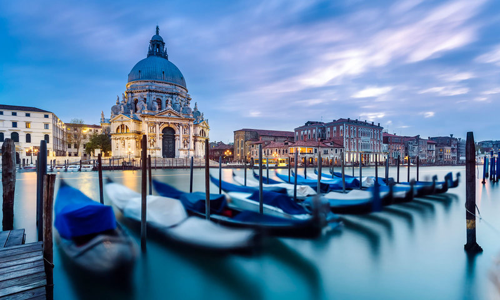

In [ ]:
content_path = '/content/images/content/venice-boat.jpg'
display(Image.open(content_path).resize((500, 300)))

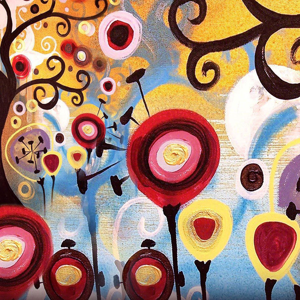

In [ ]:
style_path = '/content/images/9styles/candy.jpg'
display(Image.open(style_path).resize((300, 300)))

In [ ]:
content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
style = preprocess_batch(style)

In [ ]:
style_model = Net(ngf=128)
model_dict = torch.load('/content/drive/MyDrive/msgnet/models/my.model')
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [ ]:
def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)

In [ ]:
style_v = Variable(style)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
output = style_model(content_image)
tensor_save_bgrimage(output.data[0], 'output.jpg', False)

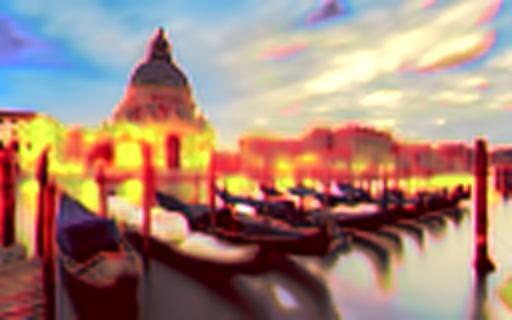

In [ ]:
display(Image.open('output.jpg'))

Result from the original article

    https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer/blob/master/msgnet.ipynb

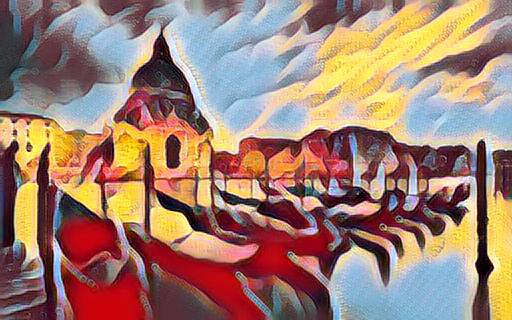

Such a difference might be because I trained my model on a smaller dataset and with only with 2 epochs (against 4 as was suggested - https://hangzhang.org/PyTorch-Encoding/tutorials/style.html#train-your-own-msg-net-model). Also, I loaded the Vgg16 model with standard weights from the pytorchvision package, and the author loaded some another one (pretrained lua-model of Vgg16). And of course it cannot be ruled out that I made mistakes when adapting the author's code)

In [ ]:
from datetime import datetime

def inference(content_path, style_path):
    display(Image.open(content_path).resize((500, 300)))
    print()
    display(Image.open(style_path).resize((300, 300)))
    print()
    content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
    style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
    style = preprocess_batch(style)
    
    style_v = Variable(style)
    content_image = Variable(preprocess_batch(content_image))
    style_model.setTarget(style_v)
    output = style_model(content_image)
    output_path = f'output + {datetime.now()}.jpg'
    tensor_save_bgrimage(output.data[0], output_path, False)
    display(Image.open(output_path))

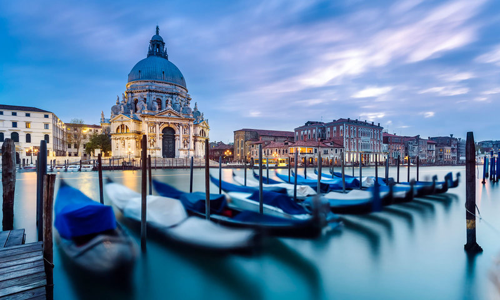

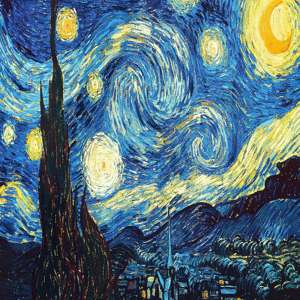

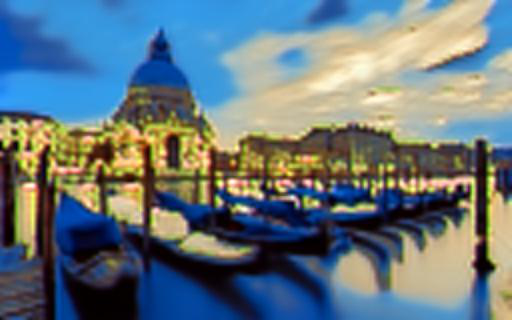

In [ ]:
inference('/content/images/content/venice-boat.jpg', '/content/images/9styles/starry_night.jpg')

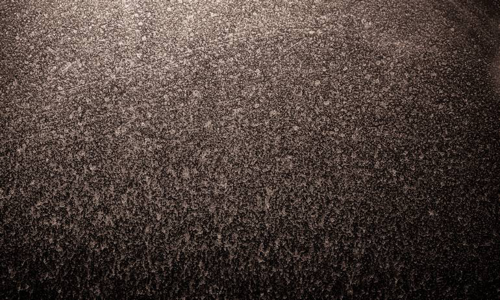

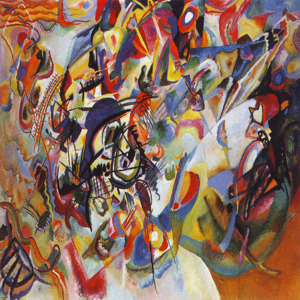

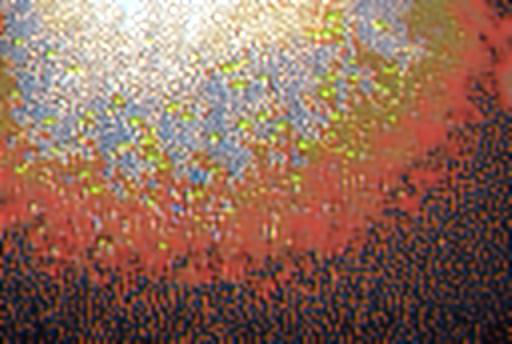

In [ ]:
inference('/content/images/content/noise.jpg', '/content/images/9styles/composition_vii.jpg')

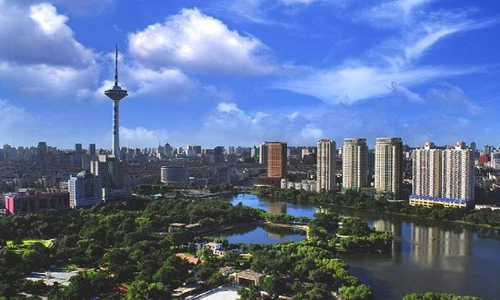

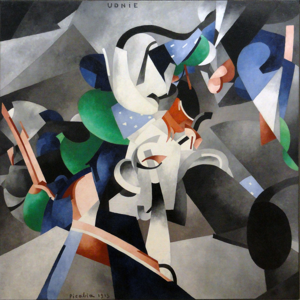

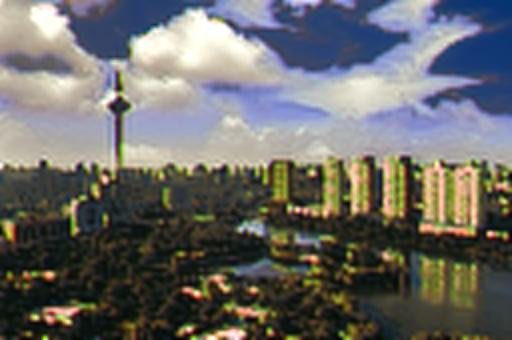

In [ ]:
inference('/content/images/content/shenyang.jpg', '/content/images/9styles/udnie.jpg')

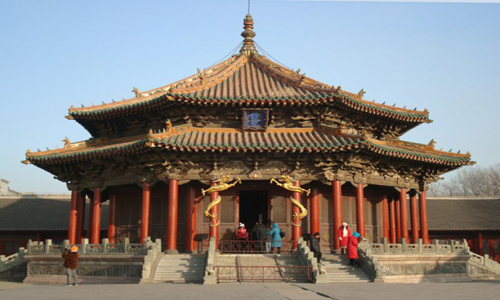

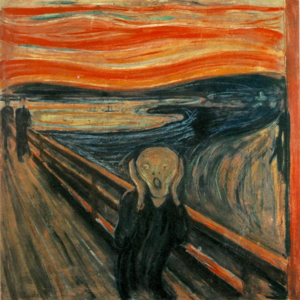

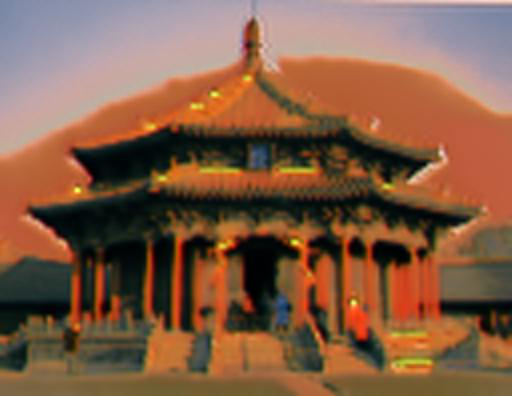

In [ ]:
inference('/content/images/content/shenyang3.jpg', '/content/images/9styles/the_scream.jpg')